# Profile

In [28]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
datadir = '../../../../Data/RSNA_2022_DATA/rsna-2022-cervical-spine-fracture-detection'
libdir = '.'
outputdir = '.'
otherdir = '.'

train_bs_ = 16 # train_batch_size
valid_bs_ = 128 # valid_batch_size
num_workers_ = 5

# CFG

In [29]:
class CFG:
    seed=42
    device='GPU' # ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    num_workers=num_workers_
    train_bs=train_bs_
    valid_bs=valid_bs_
    fold_num=5 
    
    target_cols=["C1", "C2", "C3", "C4", "C5", "C6", "C7", "OT"]
    num_classes=8 
    
    normalize_mean=[0.4824, 0.4824, 0.4824] 
    normalize_std=[0.22, 0.22, 0.22] 
    
    fold_list=[0]

    model_arch="efficientnet-b0" 
    img_size=512 
    croped_img_size = 320 # 裁剪后的图片尺寸
    weight_path = f"{outputdir}/efficientnet-b0_109_fold0_epoch13.pth" 

# Import

In [30]:
# !pip install -q git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
    
import sys; 

package_paths = [f'{libdir}pytorch-image-models-master']
for pth in package_paths:
    sys.path.append(pth)
    
import ast
from glob import glob
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm
from contextlib import contextmanager
import math

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
import timm
import warnings
import joblib
from scipy.ndimage.interpolation import zoom
import nibabel as nib
import pydicom as dicom
import gc 


if CFG.device == 'TPU':
    !pip install -q pytorch-ignite
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/tmp/ipykernel_778101/1262559851.py:43: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


In [31]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)


def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores



# 日志记录函数
def init_logger(log_file=outputdir+'/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def get_timediff(time1,time2):
    minute_,second_ = divmod(time2-time1,60)
    return f"{int(minute_):02d}:{int(second_):02d}"  


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb


def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    # data = (data * 255).astype(np.uint8)
    return data

# 87Sampler Peek Mask

In [32]:
# study_train_df = pd.read_csv(f'{datadir}/seg_25d.csv')
# print('train_df shape:', study_train_df.shape)
# study_train_df.head(3)

In [33]:
# import segmentation_models_pytorch as smp

# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.model_arch,    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path)["model"])
#     model.eval()
#     return model

# model = load_model(CFG.weight_path)
# model.eval()
# gc.collect()

In [34]:
# import random
# rand_idx = random.randint(0,len(study_train_df))
# print(f"rand_idx:{rand_idx}")
# example = study_train_df.iloc[rand_idx]
# exa_image = np.load(example["image_path"])
# exa_mask = np.load(example["mask_path"])
# print(f"exa_image.shape: {exa_image.shape}, exa_mask.shape: {exa_mask.shape}")

# exa_image = np.expand_dims((exa_image/255).transpose(2,0,1), 0)
# exa_image = torch.from_numpy(exa_image)
# exa_image = exa_image.to(device, dtype=torch.float)
# with torch.no_grad():
#     y_pred = model(exa_image)
# y_pred = y_pred.sigmoid() ####
# y_pred = (y_pred).to('cpu').numpy()
# slice_pred = y_pred[0] # 8 * img_size * img_size
# slice_mask_argmax = slice_pred.argmax(0) # img_size * img_size
# slice_mask_max = slice_pred.max(0) # img_size * img_size
# slice_mask = np.where(slice_mask_max>0.5, slice_mask_argmax, 0).astype(np.uint8)

In [35]:
# from matplotlib.patches import Rectangle

# plt.figure(figsize=(30, 20))
# img = exa_image[0][1].cpu().numpy() # 512*512; 0-1;
# slice_mask = slice_mask # 512*512; 0or1;
# label_mask = exa_mask[:,:,1].astype("uint8") # 512*512; 0-8 classes;
# plt.subplot(1, 3, 1); plt.imshow(img); plt.axis('OFF'); # 512*512; 0-1;
# plt.subplot(1, 3, 2); plt.imshow(slice_mask); plt.axis('OFF');
# plt.subplot(1, 3, 3); 
# plt.imshow(exa_mask[:,:,1]); 
# plt.axis('OFF');
# # plt.subplot(1, 3, 3); plt.imshow(slice_mask); plt.imshow(img,alpha=0.7); plt.axis('OFF');
# # # plt.colorbar()
# plt.tight_layout()
# plt.show()

# 2019Train CSV

In [36]:
study_train_df = pd.read_csv(f'{datadir}/train.csv')
print('train_df shape:', study_train_df.shape)
study_train_df.head(3)

train_df shape: (2019, 9)


,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0


In [37]:
seg_paths = glob(f"{datadir}/segmentations/*")
seg_gt_list = [path.split('/')[-1][:-4] for path in seg_paths]
print(len(seg_gt_list))
seg_gt_list[:3]

87


['1.2.826.0.1.3680043.10633',
 '1.2.826.0.1.3680043.10921',
 '1.2.826.0.1.3680043.11827']

In [38]:
study_train_df = study_train_df[~study_train_df["StudyInstanceUID"].isin(seg_gt_list)]
study_train_df.shape

(1932, 9)

In [39]:
train_slice_list = []
for file_name in tqdm(study_train_df["StudyInstanceUID"].values):
    train_image_path = glob(f"{datadir}/train_images/{file_name}/*")
    train_image_path = sorted(train_image_path, key=lambda x:int(x.split("/")[-1].replace(".dcm","")))
    for path_idx in range(len(train_image_path)):
        path1 = "nofile" if path_idx-1 < 0 else train_image_path[path_idx-1].replace(f"{datadir}/", "")
        path2 = train_image_path[path_idx].replace(f"{datadir}/", "")
        path3 = "nofile" if path_idx+1 >= len(train_image_path) else train_image_path[path_idx+1].replace(f"{datadir}/", "")
        slice_num = int(path2.split("/")[-1].replace(".dcm",""))
        train_slice_list.append([f"{file_name}_{slice_num}", file_name, slice_num, path1, path2, path3])

100%|██████████| 1932/1932 [00:03<00:00, 501.68it/s]


In [40]:
train_df = pd.DataFrame(train_slice_list, columns=["id", "StudyInstanceUID", "slice_num", "path1", "path2", "path3"])
train_df = train_df.sort_values(['StudyInstanceUID', 'slice_num'], ascending = [True, True]).reset_index(drop=True)
train_df.to_csv(f'{datadir}/train_slice_list.csv', index=False)
train_df

,id,StudyInstanceUID,slice_num,path1,path2,path3
0,1.2.826.0.1.3680043.10001_1,1.2.826.0.1.3680043.10001,1,nofile,train_images/1.2.826.0.1.3680043.10001/1.dcm,train_images/1.2.826.0.1.3680043.10001/2.dcm
1,1.2.826.0.1.3680043.10001_2,1.2.826.0.1.3680043.10001,2,train_images/1.2.826.0.1.3680043.10001/1.dcm,train_images/1.2.826.0.1.3680043.10001/2.dcm,train_images/1.2.826.0.1.3680043.10001/3.dcm
2,1.2.826.0.1.3680043.10001_3,1.2.826.0.1.3680043.10001,3,train_images/1.2.826.0.1.3680043.10001/2.dcm,train_images/1.2.826.0.1.3680043.10001/3.dcm,train_images/1.2.826.0.1.3680043.10001/4.dcm
3,1.2.826.0.1.3680043.10001_4,1.2.826.0.1.3680043.10001,4,train_images/1.2.826.0.1.3680043.10001/3.dcm,train_images/1.2.826.0.1.3680043.10001/4.dcm,train_images/1.2.826.0.1.3680043.10001/5.dcm
4,1.2.826.0.1.3680043.10001_5,1.2.826.0.1.3680043.10001,5,train_images/1.2.826.0.1.3680043.10001/4.dcm,train_images/1.2.826.0.1.3680043.10001/5.dcm,train_images/1.2.826.0.1.3680043.10001/6.dcm
...,...,...,...,...,...,...
681764,1.2.826.0.1.3680043.9997_251,1.2.826.0.1.3680043.9997,251,train_images/1.2.826.0.1.3680043.9997/250.dcm,train_images/1.2.826.0.1.3680043.9997/251.dcm,train_images/1.2.826.0.1.3680043.9997/252.dcm
681765,1.2.826.0.1.3680043.9997_252,1.2.826.0.1.3680043.9997,252,train_images/1.2.826.0.1.3680043.9997/251.dcm,train_images/1.2.826.0.1.3680043.9997/252.dcm,train_images/1.2.826.0.1.3680043.9997/253.dcm
681766,1.2.826.0.1.3680043.9997_253,1.2.826.0.1.3680043.9997,253,train_images/1.2.826.0.1.3680043.9997/252.dcm,train_images/1.2.826.0.1.3680043.9997/253.dcm,train_images/1.2.826.0.1.3680043.9997/254.dcm
681767,1.2.826.0.1.3680043.9997_254,1.2.826.0.1.3680043.9997,254,train_images/1.2.826.0.1.3680043.9997/253.dcm,train_images/1.2.826.0.1.3680043.9997/254.dcm,train_images/1.2.826.0.1.3680043.9997/255.dcm


# Dataset

In [41]:
# 构造 dataset类
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        im2 = load_dicom(f"{datadir}/{row['path2']}")   # 512*512  
        im2h = im2.shape[0]
        im2w = im2.shape[1]

        im1 = load_dicom(f"{datadir}/{row['path1']}") if row['path1'] != "nofile" else np.zeros((im2h, im2w))  # 512*512                                                       
        im3 = load_dicom(f"{datadir}/{row['path3']}") if row['path3'] != "nofile" else np.zeros((im2h, im2w))  # 512*512  

        if im1.shape !=  (im2h, im2w):
            im1 = cv2.resize(im1, (im2w, im2h))
        if im3.shape !=  (im2h, im2w):
            im3 = cv2.resize(im3, (im2w, im2h)) 
        image_list = [im1, im2, im3]
        image = np.stack(image_list, axis=2) # 512*512*3; 0-1

        # transform
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        # image = image/255.0
        image = np.transpose(image, (2, 0, 1)) # 3*img_size*img_size; 0-1
        return torch.from_numpy(image), row['StudyInstanceUID'], row['slice_num'] 

In [42]:
# 图像AUG策略
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform
)
import albumentations

from albumentations.pytorch import ToTensorV2

def get_transforms(data):
    if data == 'train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                            min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ], p=1.0)

    elif data == 'light_train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            # VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                # OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            # CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
            #              min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ], p=1.0)

    elif data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ])

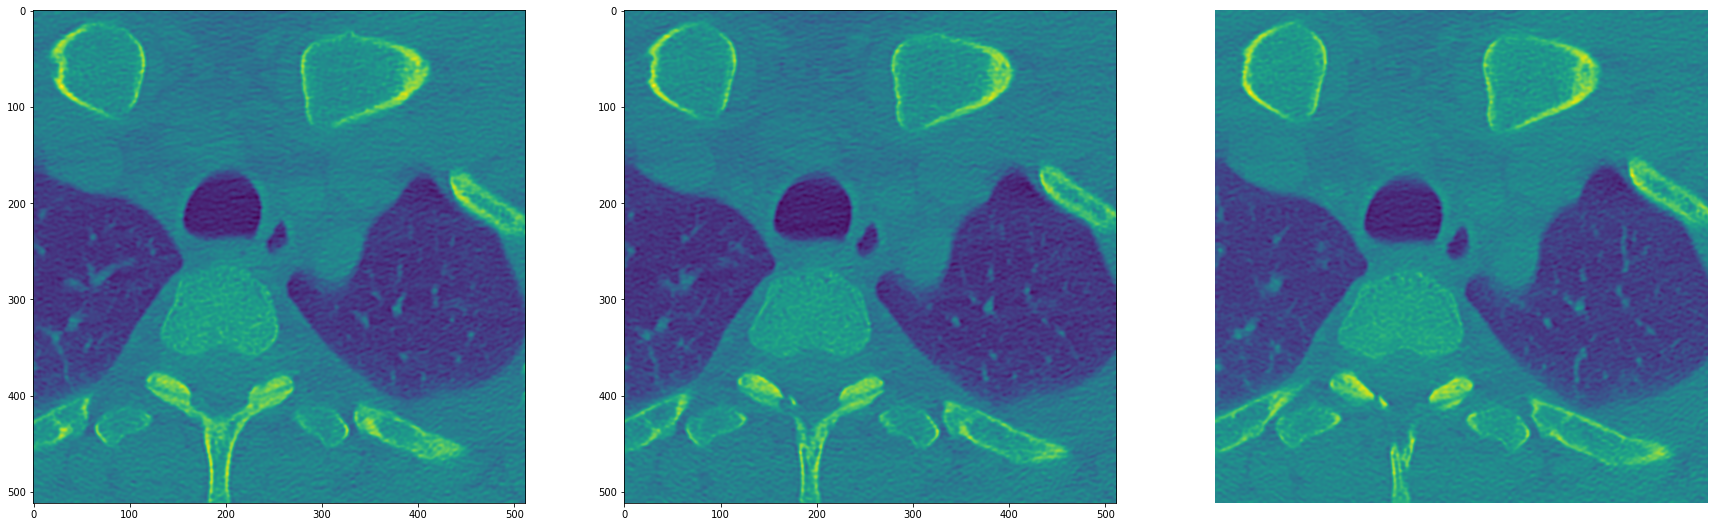

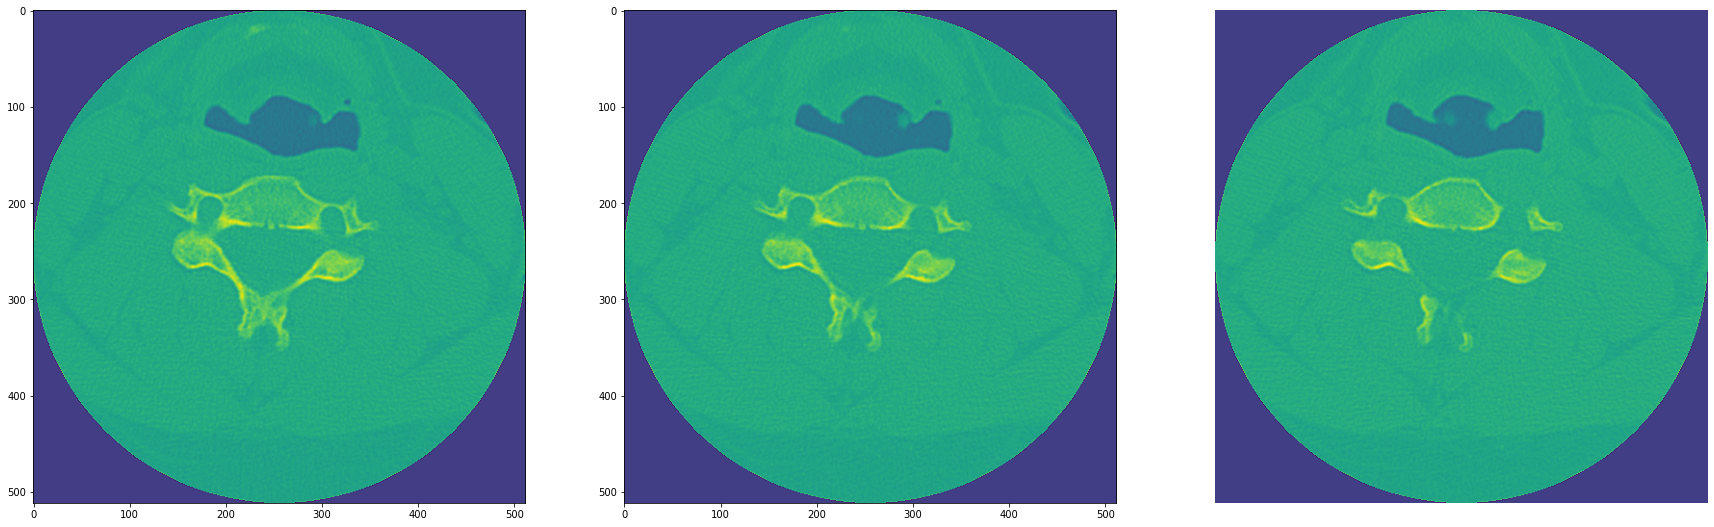

In [43]:
from pylab import rcParams
dataset_show = TrainDataset(
    train_df, 
    get_transforms("valid") # None, get_transforms("train")
    )
rcParams['figure.figsize'] = 30,20
for i in range(2):
    f, axarr = plt.subplots(1,3)
    idx = np.random.randint(0, len(dataset_show))
    img, file_name, n_slice= dataset_show[idx]
    # axarr[p].imshow(img) # transform=None
    axarr[0].imshow(img[0]); plt.axis('OFF');
    axarr[1].imshow(img[1]); plt.axis('OFF');
    axarr[2].imshow(img[2]); plt.axis('OFF');

# Model

In [44]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.model_arch,    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path)["model"])
    model.eval()
    return model

# Inference

In [45]:
# os.makedirs(f"{outputdir}/train_voxel", exist_ok=True)
# os.makedirs(f"{outputdir}/train_voxel_mask", exist_ok=True)
# for filename in train_df["StudyInstanceUID"].values:
#     os.makedirs(f"{outputdir}/train_mask/{filename}", exist_ok=True)

In [46]:
slice_class_list = []
voxel_crop_list = []
def crop_voxel(voxel_mask, last_f_name):
    area_thr = 10
    # x
    x_list = []
    length = voxel_mask.shape[0]
    for i in range(length):
        if torch.count_nonzero(voxel_mask[i]).item() >= area_thr:
            x_list.append(i)
            break
    else:
        x_list.append(0)

    for i in range(length-1, -1, -1):
        if torch.count_nonzero(voxel_mask[i]).item() >= area_thr:
            x_list.append(i)
            break
    else:
        x_list.append(length-1)

    # y
    y_list = []
    length = voxel_mask.shape[1]
    for i in range(length):
        if torch.count_nonzero(voxel_mask[:, i]).item() >= area_thr:
            y_list.append(i)
            break
    else:
        y_list.append(0)

    for i in range(length-1, -1, -1):
        if torch.count_nonzero(voxel_mask[:, i]).item() >= area_thr:
            y_list.append(i)
            break
    else:
        y_list.append(length-1)

    # z
    z_list = []
    length = voxel_mask.shape[2]
    for i in range(length):
        if torch.count_nonzero(voxel_mask[:, :, i]).item() >= area_thr:
            z_list.append(i)
            break
    else:
        z_list.append(0)

    for i in range(length-1, -1, -1):
        if torch.count_nonzero(voxel_mask[:, :, i]).item() >= area_thr:
            z_list.append(i)
            break
    else:
        z_list.append(length-1)
    # croped_voxel = voxels[x_list[0]:x_list[1]+1, y_list[0]:y_list[1]+1, z_list[0]:z_list[1]+1]
    try:
        croped_voxel_mask = voxel_mask[x_list[0]:x_list[1]+1, y_list[0]:y_list[1]+1, z_list[0]:z_list[1]+1]
    except:
        print(f"last_f_name:{last_f_name}, voxel_mask.shape:{voxel_mask.shape}, x_list:{x_list}, y_list:{y_list}, z_list:{z_list}")
        x_list = [0, voxel_mask.shape[0]-1]; y_list = [0, voxel_mask.shape[1]-1]; z_list = [0, voxel_mask.shape[2]-1]
        croped_voxel_mask = voxel_mask
    voxel_crop_list.append([last_f_name, voxel_mask.shape[1], x_list[0], x_list[1]+1, y_list[0], y_list[1]+1, z_list[0], z_list[1]+1])

    # croped_voxel = croped_voxel.to('cpu').numpy() # bs*img_size*img_size; 0-8 classes
    croped_voxel_mask = croped_voxel_mask.to('cpu').numpy().astype(np.uint8) # bs*img_size*img_size; 0-8 classes
    for x_idx in range(croped_voxel_mask.shape[0]):
        slice_mask = croped_voxel_mask[x_idx]

        unique, counts = np.unique(slice_mask, return_counts=True)
        if len(unique) == 1 and unique[0] == 0:
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0], 0])
        elif unique[0] == 0:
            unique = unique[1:]
            counts = counts[1:]
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0]+1, unique[counts.argmax()]])
        else:
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0]+1, unique[counts.argmax()]])
        
    return None, croped_voxel_mask

In [47]:
test_dataset = TrainDataset(train_df, transform=get_transforms("valid")) # get_transforms("valid")
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

model = load_model(CFG.weight_path)
model.eval()

model = torch.quantization.convert(model.eval(), inplace=False)
    
optimizer = torch.optim.SGD(model.parameters(), lr = 5e-3)
model.qconfig = torch.ao.quantization.get_default_qat_qconfig('fbgemm')


last_f_name = ""
voxel_mask = []
# voxels = []
for step, (images, file_names, n_slice) in tqdm(enumerate(test_loader),total=len(test_loader)):
    images = images.to(device, dtype=torch.float) # bs*3*image_size*image_size
    batch_size = images.size(0)
    with torch.no_grad():
        y_pred = model(images) # [B, 8, H, W]
    y_pred = y_pred.sigmoid()
    slice_mask_max = torch.max(y_pred, 1) # bs*img_size*img_size
    slice_mask = torch.where((slice_mask_max.values)>0.5, slice_mask_max.indices+1, 0) # bs*img_size*img_size; 0-8 classes
    slice_mask = torch.where(slice_mask==8,0,slice_mask).type(torch.uint8)
    # slice_mask = slice_mask.to('cpu').numpy().astype(np.uint8) # bs*img_size*img_size; 0-8 classes
    # slice_image = images[:, 1, :, :] # bs*img_size*img_size

    start_idx = 0
    for bs_idx in range(batch_size):
        f_name = file_names[bs_idx]
        if f_name != last_f_name:
            voxel_mask.append(slice_mask[start_idx:bs_idx])
            # voxels.append(slice_image[start_idx:bs_idx])
            voxel_mask = torch.cat(voxel_mask, dim=0) # n_slice*img_size*img_size; 0-8 classes
            # voxels = torch.cat(voxels, dim=0) # n_slice*img_size*img_size
            if len(voxel_mask) > 0:
                croped_voxel, croped_voxel_mask = crop_voxel(voxel_mask, last_f_name)
            last_f_name = f_name
            start_idx = bs_idx
            voxel_mask = []
            # voxels = []
        elif bs_idx == batch_size-1:
            voxel_mask.append(slice_mask[start_idx:batch_size])
            # voxels.append(slice_image[start_idx:batch_size])
voxel_mask = torch.cat(voxel_mask, dim=0)
if len(voxel_mask) > 0:
    croped_voxel, croped_voxel_mask = crop_voxel(voxel_mask, last_f_name)

  2%|▏         | 119/5327 [04:55<3:35:12,  2.48s/it]


KeyboardInterrupt: 

### replace 87 GT

In [24]:
# slice_class_list = []
# voxel_crop_list = []
for file_name in tqdm(seg_gt_list):
    ex_path = f"{datadir}/segmentations/{file_name}.nii"
    mask = nib.load(ex_path)
    mask = mask.get_fdata()  # convert to numpy array
    mask = mask[:, ::-1, ::-1].transpose(1, 0, 2)
    mask = np.clip(mask,0,8).astype(np.uint8)
    mask = np.where(mask==8, 0, mask)
    mask = np.ascontiguousarray(mask) # 512*512*slice
    
    if mask.shape[0] != 512 or mask.shape[1] != 512:
        mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)
    mask = mask.transpose(2,0,1)
    assert mask.shape[1] == mask.shape[2] == 512
    mask = torch.from_numpy(mask).to(device, dtype=torch.uint8)
    croped_voxel, croped_voxel_mask = crop_voxel(mask, file_name)

100%|██████████| 87/87 [10:02<00:00,  6.93s/it]


# post-progress 

In [48]:
import pandas as pd
import numpy as np
from tqdm import tqdm
datadir = '../../../../Data/RSNA_2022_DATA/rsna-2022-cervical-spine-fracture-detection'

### voxel_crop_list & vertebra_class

In [50]:
voxel_crop_df = pd.read_csv(f"{datadir}/voxel_crop.csv")
#voxel_crop_df = pd.DataFrame(voxel_crop_list, columns=["StudyInstanceUID", "before_image_size", "x0", "x1", "y0", "y1", "z0", "z1"]).sort_values(by=["StudyInstanceUID"])
#voxel_crop_df.to_csv(f"{datadir}/voxel_crop.csv", index=False)
voxel_crop_df # 每个study的整体crop坐标

,StudyInstanceUID,before_image_size,x0,x1,y0,y1,z0,z1
0,1.2.826.0.1.3680043.10001,512,0,268,69,396,105,442
1,1.2.826.0.1.3680043.10005,512,4,259,47,487,116,381
2,1.2.826.0.1.3680043.10014,512,0,258,63,489,79,431
3,1.2.826.0.1.3680043.10016,512,109,645,29,433,31,499
4,1.2.826.0.1.3680043.10032,512,0,289,56,450,114,377
5,1.2.826.0.1.3680043.10041,512,0,184,29,477,103,405
6,1.2.826.0.1.3680043.10051,512,0,272,73,479,76,406
7,1.2.826.0.1.3680043.10058,512,0,576,48,378,61,426
8,1.2.826.0.1.3680043.10062,512,0,363,98,426,94,376
9,1.2.826.0.1.3680043.1010,512,0,226,28,473,90,396


In [52]:
slice_class_df = pd.read_csv(f"{datadir}/slice_class.csv")
#slice_class_df = pd.DataFrame(slice_class_list, columns=["StudyInstanceUID", "new_slice_num", "old_slice_num", "vertebra_class"]).sort_values(by=["StudyInstanceUID", "new_slice_num"])
#slice_class_df.to_csv(f"{datadir}/slice_class.csv", index=False)
slice_class_df # 每张slice的所属vertebra_class(preds)

,StudyInstanceUID,new_slice_num,old_slice_num,vertebra_class
0,1.2.826.0.1.3680043.10001,0,1,5
1,1.2.826.0.1.3680043.10001,1,1,0
2,1.2.826.0.1.3680043.10001,2,2,0
3,1.2.826.0.1.3680043.10001,3,3,0
4,1.2.826.0.1.3680043.10001,4,4,0
...,...,...,...,...
13257,1.2.826.0.1.3680043.10945,214,215,7
13258,1.2.826.0.1.3680043.10945,215,216,7
13259,1.2.826.0.1.3680043.10945,216,217,7
13260,1.2.826.0.1.3680043.10945,217,217,0


In [54]:
# study_id_list = []
# slice_num_list = []
# for file_name in tqdm(voxel_crop_df["StudyInstanceUID"].values, total=len(voxel_crop_df)):
#     train_image_path = glob(f"{datadir}/train_images/{file_name}/*")
#     train_image_path = sorted(train_image_path, key=lambda x:int(x.split("/")[-1].replace(".dcm","")))
#     slice_cnt = len(train_image_path)

#     study_id_list.extend([file_name]*slice_cnt)
#     slice_num_list.extend([int(x.split("/")[-1].replace(".dcm","")) for x in train_image_path])
    
# all_slice_df = pd.DataFrame({"StudyInstanceUID":study_id_list, "slice_num":slice_num_list})
# all_slice_df.to_csv(f"{datadir}/all_slice_df.csv", index=False)
all_slice_df = pd.read_csv(f"{datadir}/all_slice_df.csv")
print(all_slice_df.shape)
all_slice_df.head(3)

(15052, 2)


,StudyInstanceUID,slice_num
0,1.2.826.0.1.3680043.10001,1
1,1.2.826.0.1.3680043.10001,2
2,1.2.826.0.1.3680043.10001,3


## gen new_df

In [55]:
new_df = []
for idx, study_id, _, x0, x1, _, _, _, _, in tqdm(voxel_crop_df.itertuples(), total=len(voxel_crop_df)):
    one_study = all_slice_df[all_slice_df["StudyInstanceUID"] == study_id].reset_index(drop=True)
    new_df.append(one_study[x0:x1])
new_df = pd.concat(new_df, axis=0).reset_index(drop=True)
new_df # 所有包含vertebra的slice

100%|██████████| 46/46 [00:00<00:00, 1028.64it/s]


,StudyInstanceUID,slice_num
0,1.2.826.0.1.3680043.10001,1
1,1.2.826.0.1.3680043.10001,2
2,1.2.826.0.1.3680043.10001,3
3,1.2.826.0.1.3680043.10001,4
4,1.2.826.0.1.3680043.10001,5
...,...,...
13257,1.2.826.0.1.3680043.10945,215
13258,1.2.826.0.1.3680043.10945,216
13259,1.2.826.0.1.3680043.10945,217
13260,1.2.826.0.1.3680043.10945,218


In [56]:
new_df = new_df.merge(voxel_crop_df, on="StudyInstanceUID", how="left") # merge study_crop_df
display(new_df) # 合并了study的crop信息
assert len(slice_class_df) == len(new_df)

,StudyInstanceUID,slice_num,before_image_size,x0,x1,y0,y1,z0,z1
0,1.2.826.0.1.3680043.10001,1,512,0,268,69,396,105,442
1,1.2.826.0.1.3680043.10001,2,512,0,268,69,396,105,442
2,1.2.826.0.1.3680043.10001,3,512,0,268,69,396,105,442
3,1.2.826.0.1.3680043.10001,4,512,0,268,69,396,105,442
4,1.2.826.0.1.3680043.10001,5,512,0,268,69,396,105,442
...,...,...,...,...,...,...,...,...,...
13257,1.2.826.0.1.3680043.10945,215,512,0,219,32,442,116,399
13258,1.2.826.0.1.3680043.10945,216,512,0,219,32,442,116,399
13259,1.2.826.0.1.3680043.10945,217,512,0,219,32,442,116,399
13260,1.2.826.0.1.3680043.10945,218,512,0,219,32,442,116,399


### slice_class_df

In [57]:
new_slice_df = pd.concat([new_df, slice_class_df[["new_slice_num", "vertebra_class"]]], axis=1)
new_slice_df # 合并 class

,StudyInstanceUID,slice_num,before_image_size,x0,x1,y0,y1,z0,z1,new_slice_num,vertebra_class
0,1.2.826.0.1.3680043.10001,1,512,0,268,69,396,105,442,0,5
1,1.2.826.0.1.3680043.10001,2,512,0,268,69,396,105,442,1,0
2,1.2.826.0.1.3680043.10001,3,512,0,268,69,396,105,442,2,0
3,1.2.826.0.1.3680043.10001,4,512,0,268,69,396,105,442,3,0
4,1.2.826.0.1.3680043.10001,5,512,0,268,69,396,105,442,4,0
...,...,...,...,...,...,...,...,...,...,...,...
13257,1.2.826.0.1.3680043.10945,215,512,0,219,32,442,116,399,214,7
13258,1.2.826.0.1.3680043.10945,216,512,0,219,32,442,116,399,215,7
13259,1.2.826.0.1.3680043.10945,217,512,0,219,32,442,116,399,216,7
13260,1.2.826.0.1.3680043.10945,218,512,0,219,32,442,116,399,217,0


### merge train.csv

In [58]:
tr_df = pd.read_csv(f"{datadir}/train.csv")
new_slice_df1 = new_slice_df.merge(tr_df, on="StudyInstanceUID", how="left")
new_slice_df1 # 合并 train.csv

,StudyInstanceUID,slice_num,before_image_size,x0,x1,y0,y1,z0,z1,new_slice_num,vertebra_class,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,512,0,268,69,396,105,442,0,5,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10001,2,512,0,268,69,396,105,442,1,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10001,3,512,0,268,69,396,105,442,2,0,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10001,4,512,0,268,69,396,105,442,3,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.10001,5,512,0,268,69,396,105,442,4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13257,1.2.826.0.1.3680043.10945,215,512,0,219,32,442,116,399,214,7,0,0,0,0,0,0,0,0
13258,1.2.826.0.1.3680043.10945,216,512,0,219,32,442,116,399,215,7,0,0,0,0,0,0,0,0
13259,1.2.826.0.1.3680043.10945,217,512,0,219,32,442,116,399,216,7,0,0,0,0,0,0,0,0
13260,1.2.826.0.1.3680043.10945,218,512,0,219,32,442,116,399,217,0,0,0,0,0,0,0,0,0


In [59]:
new_slice_df1.to_csv(f"{datadir}/train_slice.csv", index=False)

### vertebra level

In [60]:
sample_num = 24
vertebrae_df_list = []
for study_id in tqdm(np.unique(new_slice_df1["StudyInstanceUID"])):
    one_study = new_slice_df1[new_slice_df1["StudyInstanceUID"] == study_id].reset_index(drop=True)
    for cid in range(1, 8):
        one_study_cid = one_study[one_study["vertebra_class"] == cid].reset_index(drop=True)
        if len(one_study_cid) >= sample_num:
            sample_index = np.linspace(0, len(one_study_cid)-1, sample_num, dtype=int)
            one_study_cid = one_study_cid.iloc[sample_index].reset_index(drop=True)
        if len(one_study_cid) < 1:
            continue
        slice_num_list = one_study_cid["slice_num"].values.tolist()
        arow = one_study_cid.iloc[0]
        vertebrae_df_list.append([f"{study_id}_{cid}", study_id, cid, slice_num_list, arow["before_image_size"], \
            arow["x0"], arow["x1"], arow["y0"], arow["y1"], arow["z0"], arow["z1"], arow[f"C{cid}"]])

100%|██████████| 46/46 [00:00<00:00, 253.41it/s]


In [61]:
len(vertebrae_df_list)/(2019*7)

0.02250053067289323

In [64]:
# vertebrae_df = pd.DataFrame(vertebrae_df_list, columns=["study_cid", "StudyInstanceUID", "cid", "slice_num_list", \
#     "before_image_size", "x0", "x1", "y0", "y1", "z0", "z1", "label"])
# vertebrae_df.to_pickle(f"{datadir}/vertebrae_df.pkl")    
vertebrae_df = pd.read_pickle(f"{datadir}/vertebrae_df.pkl")    
vertebrae_df

,study_cid,StudyInstanceUID,cid,slice_num_list,before_image_size,x0,x1,y0,y1,z0,z1,label
0,1.2.826.0.1.3680043.10001_1,1.2.826.0.1.3680043.10001,1,"[51, 52, 53, 54, 56, 57, 58, 59, 61, 62, 63, 6...",512,0,268,69,396,105,442,0
1,1.2.826.0.1.3680043.10001_2,1.2.826.0.1.3680043.10001,2,"[81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 9...",512,0,268,69,396,105,442,0
2,1.2.826.0.1.3680043.10001_3,1.2.826.0.1.3680043.10001,3,"[40, 108, 109, 110, 111, 112, 113, 114, 115, 1...",512,0,268,69,396,105,442,0
3,1.2.826.0.1.3680043.10001_4,1.2.826.0.1.3680043.10001,4,"[127, 128, 130, 131, 132, 133, 134, 135, 136, ...",512,0,268,69,396,105,442,0
4,1.2.826.0.1.3680043.10001_5,1.2.826.0.1.3680043.10001,5,"[1, 153, 155, 156, 158, 159, 160, 161, 162, 16...",512,0,268,69,396,105,442,0
...,...,...,...,...,...,...,...,...,...,...,...,...
313,1.2.826.0.1.3680043.10945_3,1.2.826.0.1.3680043.10945,3,"[107, 108, 109, 111, 112, 115, 116, 118, 119, ...",512,0,219,32,442,116,399,0
314,1.2.826.0.1.3680043.10945_4,1.2.826.0.1.3680043.10945,4,"[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",512,0,219,32,442,116,399,0
315,1.2.826.0.1.3680043.10945_5,1.2.826.0.1.3680043.10945,5,"[164, 165, 166, 167, 168, 169, 170, 171, 183, ...",512,0,219,32,442,116,399,0
316,1.2.826.0.1.3680043.10945_6,1.2.826.0.1.3680043.10945,6,"[172, 173, 174, 175, 176, 177, 178, 179, 180, ...",512,0,219,32,442,116,399,0


### study level

In [65]:
sample_num = 90
study_df_list = []
for study_id in tqdm(np.unique(new_slice_df1["StudyInstanceUID"])):
    one_study = new_slice_df1[new_slice_df1["StudyInstanceUID"] == study_id].reset_index(drop=True)
    if len(one_study) >= sample_num:
        sample_index = np.linspace(0, len(one_study)-1, sample_num, dtype=int)
        one_study = one_study.iloc[sample_index].reset_index(drop=True)
    slice_num_list = one_study["slice_num"].values.tolist()
    arow = one_study.iloc[0]
    study_df_list.append([study_id, slice_num_list, arow["before_image_size"], arow["x0"], arow["x1"], arow["y0"], arow["y1"], arow["z0"], arow["z1"], arow["patient_overall"]])

100%|██████████| 46/46 [00:00<00:00, 877.24it/s]


In [66]:
len(study_df_list)/(2019)

0.022783556215948488

In [67]:
study_df = pd.DataFrame(study_df_list, columns=["StudyInstanceUID", "slice_num_list", "before_image_size", "x0", "x1", "y0", "y1", "z0", "z1", "label"])
study_df.to_pickle(f"{datadir}/study_df_{sample_num}.pkl") 
# study_df = pd.read_pickle(f"{datadir}/study_df_90.pkl")    
study_df

,StudyInstanceUID,slice_num_list,before_image_size,x0,x1,y0,y1,z0,z1,label
0,1.2.826.0.1.3680043.10001,"[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, ...",512,0,268,69,396,105,442,0
1,1.2.826.0.1.3680043.10005,"[5, 7, 10, 13, 16, 19, 22, 24, 27, 30, 33, 36,...",512,4,259,47,487,116,381,0
2,1.2.826.0.1.3680043.10014,"[1, 3, 6, 9, 12, 15, 18, 21, 24, 26, 29, 32, 3...",512,0,258,63,489,79,431,0
3,1.2.826.0.1.3680043.10016,"[110, 116, 122, 128, 134, 140, 146, 152, 158, ...",512,109,645,29,433,31,499,1
4,1.2.826.0.1.3680043.10032,"[1, 4, 7, 10, 13, 17, 20, 23, 26, 30, 33, 36, ...",512,0,289,56,450,114,377,0
5,1.2.826.0.1.3680043.10041,"[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25...",512,0,184,29,477,103,405,1
6,1.2.826.0.1.3680043.10051,"[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, ...",512,0,272,73,479,76,406,1
7,1.2.826.0.1.3680043.10058,"[1, 7, 13, 20, 26, 33, 39, 46, 52, 59, 65, 72,...",512,0,576,48,378,61,426,0
8,1.2.826.0.1.3680043.10062,"[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, ...",512,0,363,98,426,94,376,0
9,1.2.826.0.1.3680043.1010,"[1, 3, 6, 8, 11, 13, 16, 18, 21, 23, 26, 28, 3...",512,0,226,28,473,90,396,1


In [69]:
# plt.figure(figsize=(30, 20))
# img = images[0].cpu().numpy().transpose(1,2,0)
# plt.subplot(1, 3, 1); plt.imshow(slice_mask); plt.axis('OFF');
# plt.subplot(1, 3, 2); plt.imshow(img); plt.axis('OFF');
# plt.subplot(1, 3, 3); plt.imshow(slice_mask); plt.imshow(img,alpha=0.7); plt.axis('OFF');
# # # plt.colorbar()
# plt.tight_layout()
# plt.show()